# Sample Tellus Monitor

#### Description: 
##### This script analyzes Tellus' rr and hr data for 5 users aggregated at the minute level. Alerts are created for readings out of a user's normal range, when compared to an exponentially weighted moving average using a window of 360 minutes. Red alerts are given for two abnormal biomarkers and yellow alerts are given for one, while specifying peak vs. depression. Daily summaries are also provided for hardware debugging and health tracking purposes. Finally, a simple Kalman filter is applied to the data as an illustrative example to explore the impact of different methods on signal detection of true peaks amongst noisy readings from radar devices. 

#### Statistical issues: 
##### Alerts are sensitive to the selected moving average window type and size. Various combinations were tested, but parameters would be chosen more rigorously in a real application. A Kalman filter might be a better choice than a moving average to identify  peaks because it allows us to quickly estimate the true value of noisy, high frequency data. Ideally the input data would be in seconds, not minutes.
##### Other issues considered are the fact that sample size is low and each user only has about 3 days of data, which may not be representative. There is also a lot of missing data, especially for hr, and low rr values, which do not seem feasible. Information on  variability and measurement error of the Tellus device would be helpful to better account for this. Other features to consider adding are motion data (to understand what the user was doing at the time of each measurement) and follow up data from users (if possible, to compare  medical events with the device measurements and alerts). 

#### Scalability: 
##### To run this code in production with real-time data, PySpark and a stream processing tool such as Amazon Kinesis can be used. Kalman filters work well for continuous monitoring data processing. Alerts deployed to users might incorporate additional logic to limit repetition (e.g., send alert at first indication of a peak and then wait before sending another, unless a critical threshold is met). 


In [1]:
import boto3
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.stats
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

In [2]:
## Import data

df = pd.read_csv("s3://sample-tellus-monitor/raw_data")

In [3]:
## Clean data

df = df[df.in_room == 1]
df['hr'] = df['hr'].replace(-1, np.nan) 
df['rr'] = df['rr'].replace(-1, np.nan)

In [4]:
## Calculate exponential weighted moving averages and std devs
##     (excludes the current point, which may not be available in real-time)

df['rr_ewma'] = df.groupby(['user_id'])['rr'].apply(lambda x: x.ewm(span=360).mean().shift())
df['hr_ewma'] = df.groupby(['user_id'])['hr'].apply(lambda x: x.ewm(span=360).mean().shift())
df['rr_ewsd'] = df.groupby(['user_id'])['rr'].apply(lambda x: x.ewm(span=360).std().shift())
df['hr_ewsd'] = df.groupby(['user_id'])['hr'].apply(lambda x: x.ewm(span=360).std().shift())

In [5]:
## Calculate z scores

df['rr_z'] = (df['rr'] - df['rr_ewma']) / df['rr_ewsd']
df['hr_z'] = (df['hr'] - df['hr_ewma']) / df['hr_ewsd']

In [6]:
## Create minute-level alerts
##    (with additional boundaries added from medical literature to ensure safety)

df['alert'] = 'green'

df.loc[((df['hr_z']>=2) | (df['hr']>100)),
       'alert'] = 'yellow: hr high'

df.loc[((df['rr_z']>=2) | (df['rr']>25)),
       'alert'] = 'yellow: rr high'

df.loc[((df['hr_z']<=-2) | (df['hr']<50)),
       'alert'] = 'yellow: hr low'

df.loc[((df['rr_z']<=-2) | (df['rr']<12)),
       'alert'] = 'yellow: rr low'

df.loc[((df['hr_z']>=2) | (df['hr']>100)) & 
       ((df['rr_z']>=2) | (df['rr']>25)),
       'alert'] = 'red: both high'

df.loc[((df['hr_z']<=-2) | (df['hr']<50)) & 
       ((df['rr_z']<=-2) | (df['rr']<12)),
       'alert'] = 'red: both low'

df.loc[((df['hr_z']>=2) | (df['hr']>100)) & 
       ((df['rr_z']<=-2) | (df['rr']<12)),
       'alert'] = 'red: hr high, rr low'

df.loc[((df['hr_z']<=-2) | (df['hr']<50)) & 
       ((df['rr_z']>=2) | (df['rr']>25)),
       'alert'] = 'red: hr low, rr high'

In [7]:
## Examine alerts by alert type and user
##     (excludes each user's first 360 minutes of data, which was used as a baseline)

df1 = df.groupby(['user_id']).apply(lambda x:x.iloc[360:])
df1['date'] = pd.to_datetime(df1['ts']).dt.date
df1 = df1.reset_index(drop=True)

total_alerts = pd.DataFrame(df1['alert'].value_counts())

alerts_per_user = pd.DataFrame(df1.groupby(['user_id'])['alert'].value_counts())

alerts_per_user.head()

alert
user_id alert                      
1       green                  2300
        yellow: rr low          357
        yellow: rr high          61
        red: hr high, rr low     54
        yellow: hr high          29

In [8]:
## Create daily summary alerts 
##     (for admin / debugging purposes)

admin_summary = df1.groupby(['user_id','date']).agg(
    {'date':'count'}).rename(
    columns={'date':'in_room_minutes'})

admin_summary['rr_pct_na'] = np.divide(
    df1.groupby(['user_id','date'])['rr'].apply(
        lambda x: x.isnull().values.sum()),
    admin_summary['in_room_minutes'])

admin_summary['hr_pct_na'] = np.divide(
    df1.groupby(['user_id','date'])['hr'].apply(
        lambda x: x.isnull().values.sum()),
    admin_summary['in_room_minutes'])

admin_summary['rr_pct_zero'] = np.divide(
    df1.groupby(['user_id','date'])['rr'].agg(
        lambda x: x.eq(0).sum()),
    admin_summary['in_room_minutes'])  

admin_summary['hr_pct_zero'] = np.divide(
    df1.groupby(['user_id','date'])['hr'].agg(
        lambda x: x.eq(0).sum()),
    admin_summary['in_room_minutes']) 

admin_summary.head()


in_room_minutes  rr_pct_na  hr_pct_na  rr_pct_zero  \
user_id date                                                             
1       2019-03-20              281   0.000000   0.217082     0.000000   
        2019-03-21              680   0.002941   0.332353     0.054412   
        2019-03-22              605   0.004959   0.309091     0.082645   
        2019-03-23              685   0.005839   0.322628     0.164964   
        2019-03-24              567   0.001764   0.299824     0.014109   

                    hr_pct_zero  
user_id date                     
1       2019-03-20          0.0  
        2019-03-21          0.0  
        2019-03-22          0.0  
        2019-03-23          0.0  
        2019-03-24          0.0

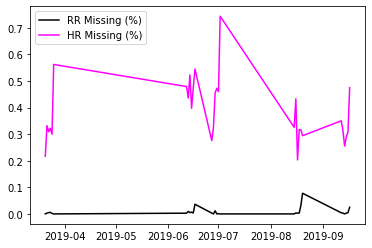

In [9]:
## Examine missing data over time

admin_summary = admin_summary.reset_index()

plt.plot(admin_summary.date, admin_summary.rr_pct_na, label='RR Missing (%)', color='black')
plt.plot(admin_summary.date, admin_summary.hr_pct_na, label='HR Missing (%)', color='magenta')
plt.legend(loc='upper left')
plt.show()

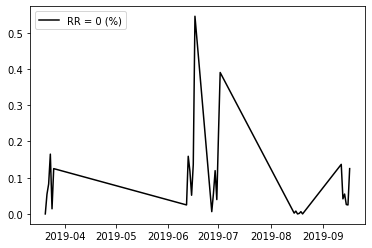

In [10]:
## Examine rr equal to zero over time

plt.plot(admin_summary.date, admin_summary.rr_pct_zero, label='RR = 0 (%)', color='black')
plt.legend(loc='upper left')
plt.show()

In [11]:
## Create daily summary alerts 
##     (for users / health tracking purposes)


# Calculate summary statistics
user_summary = df1.groupby(['user_id','date']).agg(
    {'date':'count',
     'rr':['mean','min','max'],
     'hr':['mean','min','max']}) 

user_summary.columns = user_summary.columns.droplevel(0)
user_summary.columns = ['in_room_minutes',
                        'rr_mean','rr_min','rr_max',
                        'hr_mean','hr_min','hr_max']


# Calculate frequency of each alert type
temp = pd.DataFrame(
    df1.groupby(['user_id','date'])\
    ['alert'].value_counts())\
    .rename(columns={'alert':'count'}).reset_index() 

temp = temp.set_index(["user_id", "date"]).pivot(columns="alert")['count']
temp = temp.div(user_summary['in_room_minutes'], axis=0)


# Join tables
user_summary = pd.merge(user_summary, 
                        temp, 
                        left_index=True, 
                        right_index=True).reset_index()

user_summary = user_summary.replace(np.nan,0) 


# Add total red and yellow alerts
user_summary['total_red'] = user_summary['red: both high'] +\
                            user_summary['red: both low'] +\
                            user_summary['red: hr high, rr low'] +\
                            user_summary['red: hr low, rr high']

user_summary['total_yellow'] = user_summary['yellow: hr high'] +\
                               user_summary['yellow: rr high'] +\
                               user_summary['yellow: hr low'] +\
                               user_summary['yellow: rr low']

user_summary.head()

,user_id,date,in_room_minutes,rr_mean,rr_min,rr_max,hr_mean,hr_min,hr_max,green,red: both high,red: both low,"red: hr high, rr low","red: hr low, rr high",yellow: hr high,yellow: hr low,yellow: rr high,yellow: rr low,total_red,total_yellow
0,1,2019-03-20,281,16.272864,4.90625,31.429786,63.332830,51.798845,91.025152,0.950178,0.000000,0.000000,0.003559,0.0,0.010676,0.000000,0.032028,0.003559,0.003559,0.046263
1,1,2019-03-21,680,13.633549,0.00000,29.936545,66.361729,10.000000,99.609375,0.773529,0.000000,0.029412,0.017647,0.0,0.004412,0.000000,0.017647,0.157353,0.047059,0.179412
2,1,2019-03-22,605,14.891820,0.00000,29.561325,66.628470,49.218750,99.609375,0.809917,0.000000,0.000000,0.028099,0.0,0.021488,0.003306,0.023140,0.114050,0.028099,0.161983
3,1,2019-03-23,685,12.856314,0.00000,30.718494,69.516138,50.812163,120.000000,0.741606,0.014599,0.000000,0.018978,0.0,0.004380,0.000000,0.004380,0.216058,0.033577,0.224818
4,1,2019-03-24,567,16.385294,0.00000,30.468750,65.889346,50.651686,99.609375,0.883598,0.001764,0.000000,0.014109,0.0,0.010582,0.000000,0.038801,0.051146,0.015873,0.100529


In [12]:
## Function to graph daily alerts per user 
##     (% green, % yellow, % red)

def user_alert_plot(user_id):
    
    plt.bar(user_summary[user_summary['user_id']==user_id].date, 
            user_summary[user_summary['user_id']==user_id]['total_red'], 
            label='Red', color='red')
    
    plt.bar(user_summary[user_summary['user_id']==user_id].date, 
            user_summary[user_summary['user_id']==user_id]['total_yellow'], 
            label='Yellow', color='yellow', 
            bottom=user_summary[user_summary['user_id']==user_id]['total_red'])
        
    plt.bar(user_summary[user_summary['user_id']==user_id].date, 
            user_summary[user_summary['user_id']==user_id]['green'], 
            label='Green (%)', color='limegreen', 
            bottom=user_summary[user_summary['user_id']==user_id]['total_red'] + \
            user_summary[user_summary['user_id']==user_id]['total_yellow'])

    plt.show()

In [13]:
## Function to graph daily alerts per user 
##     (% yellow and red, by alert type)

def detailed_user_alert_plot(user_id):
        
    plt.bar(user_summary[user_summary['user_id']==user_id].date, 
            user_summary[user_summary['user_id']==user_id]['red: both high'], 
            label='Both high', color='darkred')
    
    plt.bar(user_summary[user_summary['user_id']==user_id].date, 
            user_summary[user_summary['user_id']==user_id]['red: both low'], 
            label='Both low', color='crimson', 
            bottom=user_summary[user_summary['user_id']==user_id]['red: both high'])
    
    plt.bar(user_summary[user_summary['user_id']==user_id].date, 
            user_summary[user_summary['user_id']==user_id]['red: hr high, rr low'], 
            label='HR high, RR low', color='red', 
            bottom=user_summary[user_summary['user_id']==user_id]['red: both high']+\
            user_summary[user_summary['user_id']==user_id]['red: both low'])
    
    plt.bar(user_summary[user_summary['user_id']==user_id].date, 
            user_summary[user_summary['user_id']==user_id]['red: hr low, rr high'], 
            label='HR low, RR high', color='salmon', 
            bottom=user_summary[user_summary['user_id']==user_id]['red: both high']+\
            user_summary[user_summary['user_id']==user_id]['red: both low']+\
            user_summary[user_summary['user_id']==user_id]['red: hr high, rr low'])
    
    plt.bar(user_summary[user_summary['user_id']==user_id].date, 
            user_summary[user_summary['user_id']==user_id]['yellow: hr high'], 
            label='HR high', color='orange', 
            bottom=user_summary[user_summary['user_id']==user_id]['red: both high']+\
            user_summary[user_summary['user_id']==user_id]['red: both low']+\
            user_summary[user_summary['user_id']==user_id]['red: hr high, rr low']+\
            user_summary[user_summary['user_id']==user_id]['red: hr low, rr high'])
    
    plt.bar(user_summary[user_summary['user_id']==user_id].date, 
            user_summary[user_summary['user_id']==user_id]['yellow: rr high'], 
            label='RR high', color='gold', 
            bottom=user_summary[user_summary['user_id']==user_id]['red: both high']+\
            user_summary[user_summary['user_id']==user_id]['red: both low']+\
            user_summary[user_summary['user_id']==user_id]['red: hr high, rr low']+\
            user_summary[user_summary['user_id']==user_id]['red: hr low, rr high']+\
            user_summary[user_summary['user_id']==user_id]['yellow: hr high'])
    
    plt.bar(user_summary[user_summary['user_id']==user_id].date, 
            user_summary[user_summary['user_id']==user_id]['yellow: hr low'], 
            label='HR low', color='yellow', 
            bottom=user_summary[user_summary['user_id']==user_id]['red: both high']+\
            user_summary[user_summary['user_id']==user_id]['red: both low']+\
            user_summary[user_summary['user_id']==user_id]['red: hr high, rr low']+\
            user_summary[user_summary['user_id']==user_id]['red: hr low, rr high']+\
            user_summary[user_summary['user_id']==user_id]['yellow: hr high']+\
            user_summary[user_summary['user_id']==user_id]['yellow: rr high'])
    
    plt.bar(user_summary[user_summary['user_id']==user_id].date, 
            user_summary[user_summary['user_id']==user_id]['yellow: rr low'], 
            label='RR low', color='khaki', 
            bottom=user_summary[user_summary['user_id']==user_id]['red: both high']+\
            user_summary[user_summary['user_id']==user_id]['red: both low']+\
            user_summary[user_summary['user_id']==user_id]['red: hr high, rr low']+\
            user_summary[user_summary['user_id']==user_id]['red: hr low, rr high']+\
            user_summary[user_summary['user_id']==user_id]['yellow: hr high']+\
            user_summary[user_summary['user_id']==user_id]['yellow: rr high']+\
            user_summary[user_summary['user_id']==user_id]['yellow: hr low'])

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    
    plt.show()

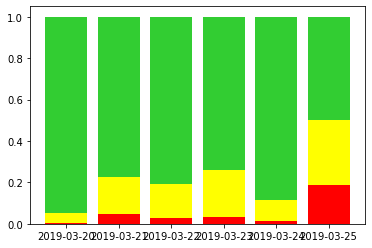

In [14]:
user_alert_plot(1)

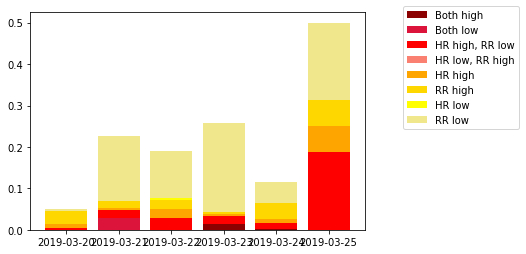

In [15]:
detailed_user_alert_plot(1)

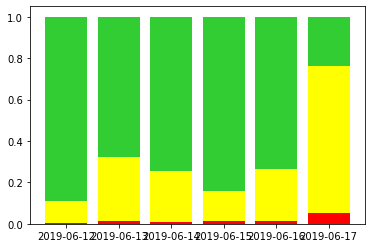

In [16]:
user_alert_plot(2)

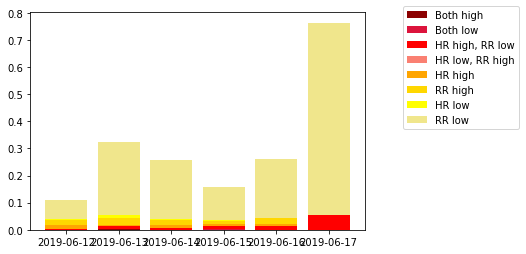

In [17]:
detailed_user_alert_plot(2)

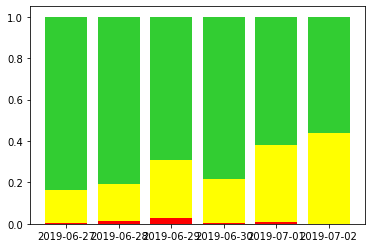

In [18]:
user_alert_plot(3)

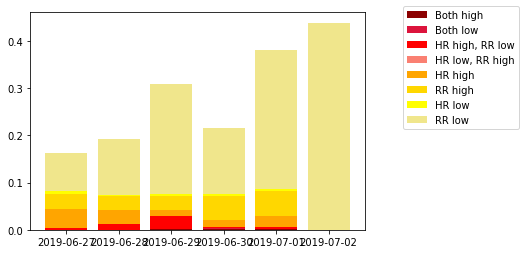

In [19]:
detailed_user_alert_plot(3)

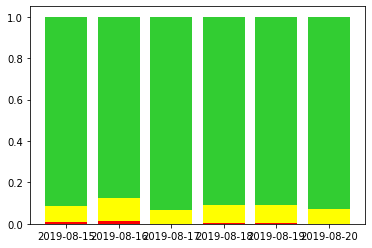

In [20]:
user_alert_plot(4)

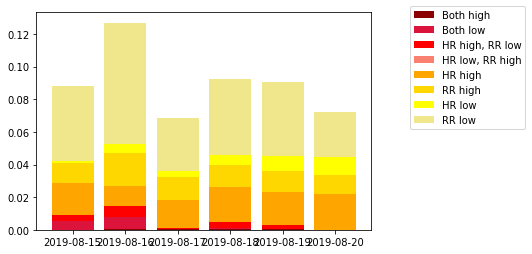

In [21]:
detailed_user_alert_plot(4)

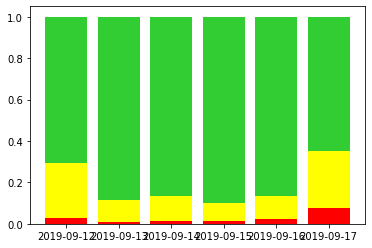

In [22]:
user_alert_plot(5)

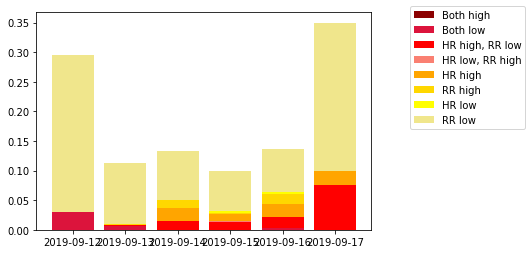

In [23]:
detailed_user_alert_plot(5)

In [24]:
## Compare EWMA to Kalman filters, as a starting point for future analysis

def kf(df,biomarker,initial_mean):
    # Kalman filter
    biomarker_no_na = df[biomarker].ffill().bfill()
    kf = KalmanFilter(transition_matrices = [1], 
                     observation_matrices = [1], 
                     initial_state_mean = initial_mean,
                     initial_state_covariance = 1, 
                     observation_covariance = 1, 
                     transition_covariance = 0.01)
    state_means, _ = kf.filter(biomarker_no_na)
    # Plot comparison of results
    plt.xlabel([])
    plt.xticks([])
    plt.plot(df.ts, df[biomarker], label='Actual', color='skyblue')
    plt.plot(df.ts, df[biomarker+"_ewma"], label='EWMA', color='black')
    plt.plot(df.ts, state_means, label='KF', color='magenta')
    plt.legend(loc='upper left')
    return plt


<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

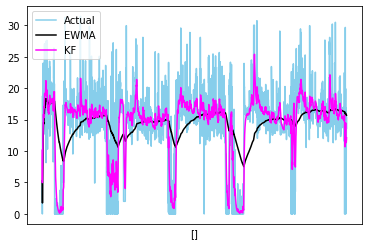

In [25]:
kf(df[df['user_id']==1],'rr',15)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

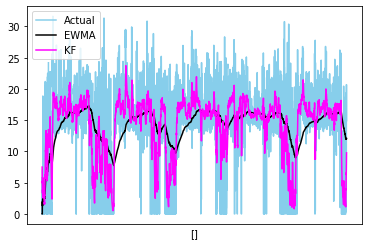

In [26]:
kf(df[df['user_id']==2],'rr',15)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

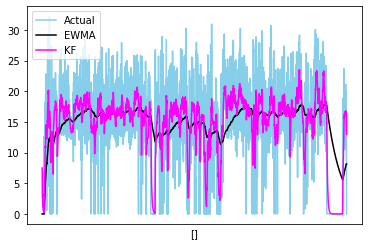

In [27]:
kf(df[df['user_id']==3],'rr',15)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

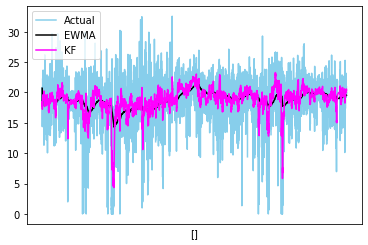

In [28]:
kf(df[df['user_id']==4],'rr',15)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

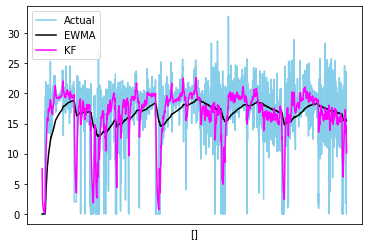

In [29]:
kf(df[df['user_id']==5],'rr',15)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

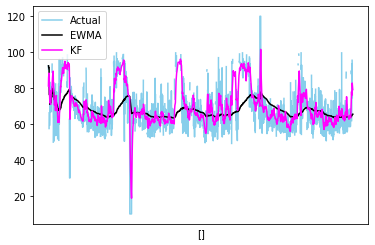

In [30]:
kf(df[df['user_id']==1],'hr',70)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

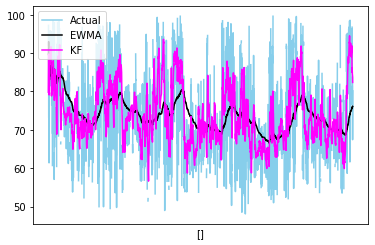

In [31]:
kf(df[df['user_id']==2],'hr',70)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

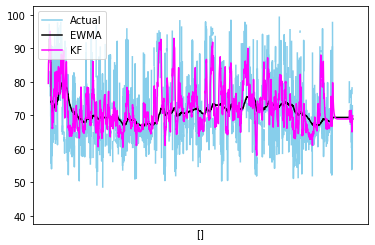

In [32]:
kf(df[df['user_id']==3],'hr',70)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

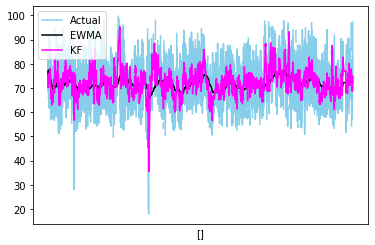

In [33]:
kf(df[df['user_id']==4],'hr',70)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

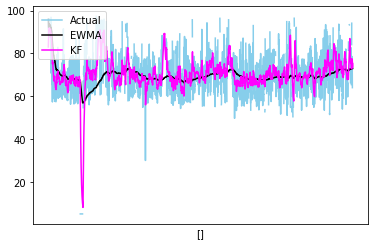

In [34]:
kf(df[df['user_id']==5],'hr',70)